In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import torch
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay   
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.loss_functions as lf

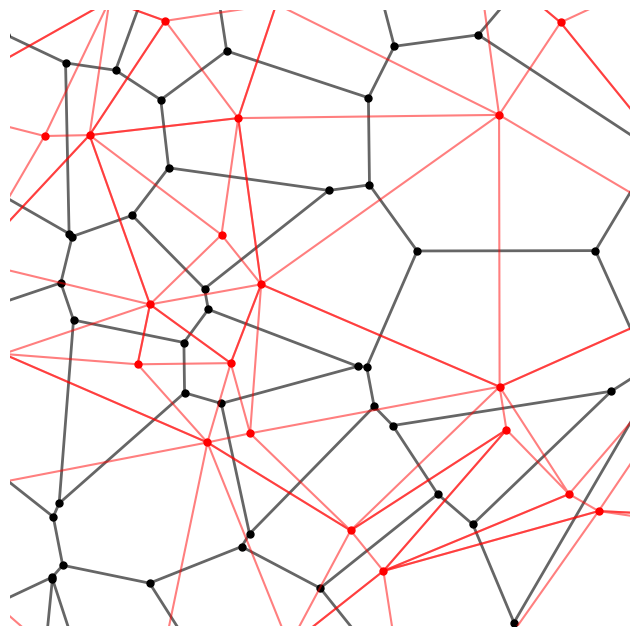

In [13]:
N = 40

# Improve reproducibility
torch.manual_seed(69)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(69)

# Generate N site positions
site_positions = np.random.rand(N, 2) * 100

def plot_voronoi_diagram(site_positions, output):
    # Create a Voronoi diagram
    vor = Voronoi(site_positions)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=2, line_alpha=0.6, point_size=2)

    # Add site positions
    ax.plot(site_positions[:, 0], site_positions[:, 1], 'ro', markersize=5, label='Sites')

    # Add vertices (black)
    ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'o', markersize=5, label='Vertices', color='black')

    # Make the connection between adjacent sites
    tri = Delaunay(site_positions)
    for simplex in tri.simplices:
        ax.plot(site_positions[simplex, 0], site_positions[simplex, 1], 'r-', alpha=0.5)

    # Crop important area
    ax.set_xlim(20, 80)
    ax.set_ylim(20, 80)

    # Remove all axes
    ax.axis('off')

    # Save as svg
    plt.savefig(output, format='svg', bbox_inches='tight')
    plt.show()

    # DEBUG: Show the Voronoi
    # cell_centers = np.array([vor.vertices[vor.regions[i]].mean(axis=0) for i in range(len(vor.regions)) if len(vor.regions[i]) > 0])
    # ax.plot(cell_centers[:, 0], cell_centers[:, 1], 'go', markersize=5, label='Cell Centers')

plot_voronoi_diagram(site_positions, 'voronoi_diagram.svg')

Energy: 7.316829681396484
Energy: 7.30354642868042
Energy: 7.290368556976318
Energy: 7.277290344238281
Energy: 7.2643632888793945
Energy: 7.251690864562988
Energy: 7.239087104797363
Energy: 7.226537227630615
Energy: 7.214061260223389
Energy: 7.201688289642334
Energy: 7.18936014175415
Energy: 7.1771063804626465
Energy: 7.164918422698975
Energy: 7.152783393859863
Energy: 7.140708923339844
Energy: 7.128692626953125
Energy: 7.116738796234131
Energy: 7.104844570159912
Energy: 7.092990398406982
Energy: 7.081189155578613
Energy: 7.069455146789551
Energy: 7.057747840881348
Energy: 7.046311378479004
Energy: 7.034955024719238
Energy: 7.02392578125
Energy: 7.013030529022217
Energy: 7.002162933349609
Energy: 6.991316318511963
Energy: 6.980494976043701
Energy: 6.9697136878967285
Energy: 6.958946228027344
Energy: 6.948246002197266
Energy: 6.93755578994751
Energy: 6.926883220672607
Energy: 6.916280269622803
Energy: 6.905738830566406
Energy: 6.895180702209473
Energy: 6.884616374969482
Energy: 6.874041

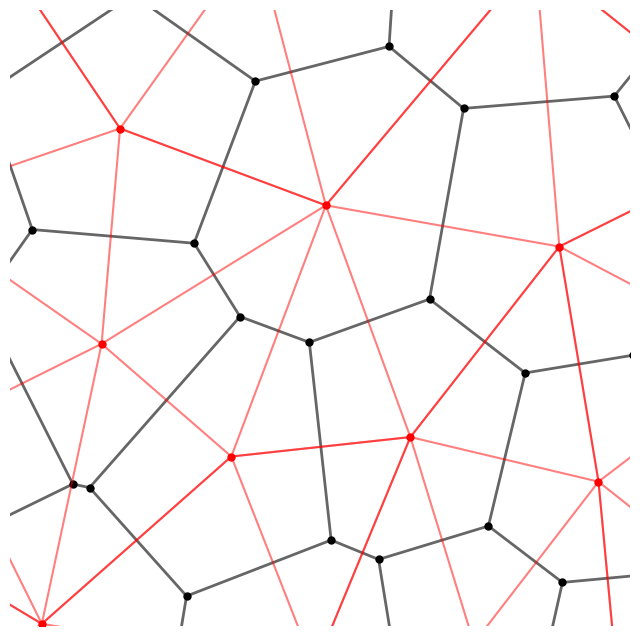

In [ ]:
# Optimize the site position with pytorch to minimize the CVT energy
site_positions_tensor = torch.tensor(site_positions, dtype=torch.float32, requires_grad=True, device=0)
optimizer = torch.optim.Adam([site_positions_tensor], lr=0.01)
for _ in range(1000):
    optimizer.zero_grad()
    
    d3dsimplices = Delaunay(site_positions_tensor.detach().cpu().numpy()).simplices

    cvt_loss = lf.compute_cvt_loss_vectorized_delaunay(site_positions_tensor, None, d3dsimplices, max_distance=100)
    energy = cvt_loss.mean()
    energy.backward()
    print(f'Energy: {energy.item()}')
    optimizer.step()

# Plot the optimized Voronoi diagram
optimized_site_positions = site_positions_tensor.detach().cpu().numpy()
plot_voronoi_diagram(optimized_site_positions, 'optimized_voronoi_diagram.svg')